In [1]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [11]:
from env import ActionOffsetLunarLander, collect_trajectories
from algorithms import NoOffsetDDPG, NaiveDDPG, OffsetMLPDDPG

In [26]:
with open("manually_saved_runs/no_offset_ddpg_0/config.json") as fp:
    config = json.load(fp)
no_offset = NoOffsetDDPG(config, load_dir="manually_saved_runs/no_offset_ddpg_0")

with open("manually_saved_runs/naive_ddpg_1/config.json") as fp:
    config = json.load(fp)
naive = NaiveDDPG(config, load_dir="manually_saved_runs/naive_ddpg_1")

with open("manually_saved_runs/no_offset_ddpg_0/config.json") as fp:
    config = json.load(fp)
offset_mlp = OffsetMLPDDPG(config, load_dir="manually_saved_runs/no_offset_ddpg_0",
                            offset_net_path="notebooks/output/sas_to_offset_MLP_1_bestval.pt")


In [27]:
max_action_offset = 0.5
num_tasks = 20
num_episodes = 1

def task_returns(trainer, action_dim):
    task_params = np.zeros((num_tasks, 2))
    task_params[:, action_dim] = np.linspace(-max_action_offset, max_action_offset, num_tasks)
    
    policy = trainer.current_policy()
    env = ActionOffsetLunarLander(task_params, 0)
    policy.task_params = task_params
    
    #TODO: collect trajectories eval isn't actually deterministic...
    task_trajs, _, _ = collect_trajectories(env, trainer.wrapped_policy, list(range(num_tasks)), num_episodes, eval=True)
    
    return [
        np.mean([sum(traj.rewards) for traj in trajs])
        for trajs in task_trajs
    ]

In [28]:
returns = {
    "No Offset": [
        task_returns(no_offset, 0),
        task_returns(no_offset, 1)
    ],
    "Naive": [
        task_returns(naive, 0),
        task_returns(naive, 1)
    ],
    "Offset Correction MLP": [
        task_returns(offset_mlp, 0),
        task_returns(offset_mlp, 1)
    ],
}
# returns["Offset Correction MLP"] = [
#     task_returns(offset_mlp, 0),
#     task_returns(offset_mlp, 1)
# ]


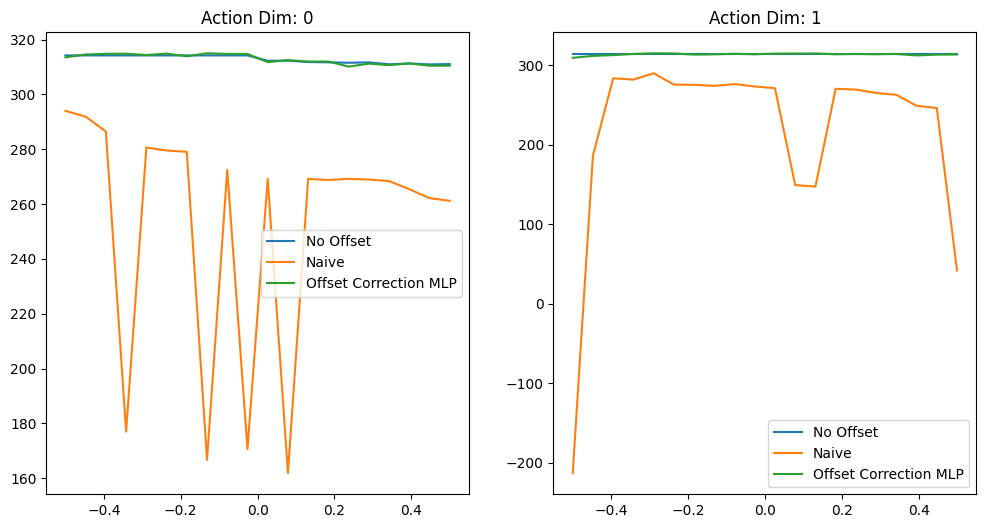

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
x = np.linspace(-max_action_offset, max_action_offset, num_tasks)
for i in range(2):
    for key in returns.keys():
        axs[i].plot(x, returns[key][i], label=key)
    axs[i].set_title(f"Action Dim: {i}")
    axs[i].legend()

In [ ]:
task_params = np.zeros((num_tasks, 2))
task_params[:, 0] = np.linspace(-max_action_offset, max_action_offset, num_tasks)

policy = naive.current_policy()
env = ActionOffsetLunarLander(task_params, 0)
policy.task_params = task_params

task_index = 0
#task_index = len(task_params) - 1
task_trajs, _, frames = collect_trajectories(env, policy, [task_index], 4, render=True)
from gymnasium.utils.save_video import save_video
save_video(
    frames[0],
    "temp",
    episode_trigger=lambda x: True,
    fps=env.metadata["render_fps"],
    name_prefix=f"task_{task_index}.offset_{env.task_params[task_index, 0]:.2f}_{env.task_params[task_index, 1]:.2f}"
)

Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/task_0.offset_-1.00_0.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/task_0.offset_-1.00_0.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/task_0.offset_-1.00_0.00-episode-0.mp4


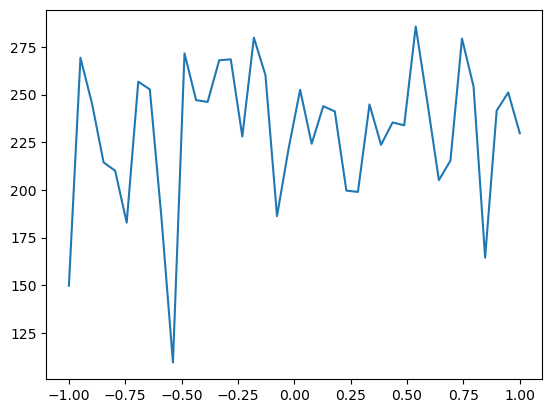

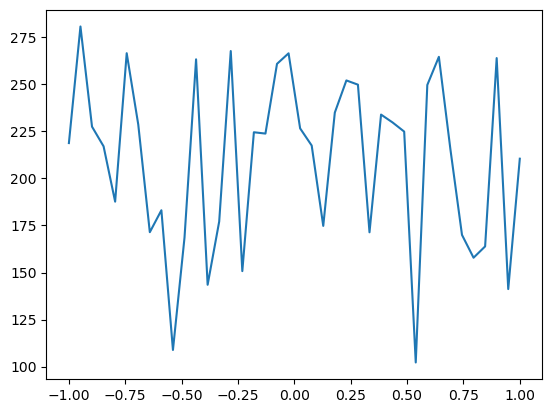

In [20]:
plot_1d(no_offset, 0)
plot_1d(no_offset, 1)

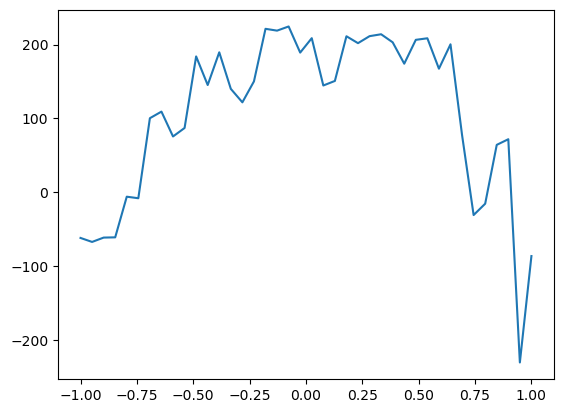

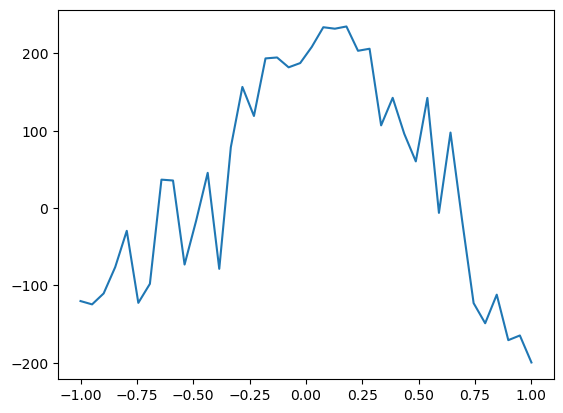

In [19]:
plot_1d(naive, 0)
plot_1d(naive, 1)